# Procesado Espectros Raman NANOBASE

En este *Notebook* se realiza un preprocesado básico a los espectros Raman medidos con Nanobase. 

Los datos obtenidos de NanoBase corresponden a espectros en bruto a los que se les ha restado el *background*. El programa de medición no realiza ningun otro tipo de tratamiento a los datos. Por ello es necesario realizar diferentes pasos previos al análisis de los espectros:

1. Whittaker Smoother: Método de suavizado aplicado a señales con la finalidad de reducir el ruido, conservando los picos caracteristicos del material. El método funciona minimizando la suma de las diferencias al cuadrado entre cada punto de datos y su estimación suavizada, sujeto a una restricción de que la segunda diferencia de los valores suavizados es pequeña. Esta restricción tiene el efecto de penalizar las variaciones en la tasa de cambio de los valores suavizados, resultando en una señal más suave.

2. Baseline: 

Al contrario que en el preprocesado de la Sonda Raman de 532nm, no es necesario corregir el Background ya que el propio software de medida se encarga de hacerlo.


In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, Normalizer
from scipy.linalg import solveh_banded  # para hacer ALS
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelextrema
from itertools import product
from scipy.signal import savgol_filter
from functools import reduce

# Directorio en el que se encuentran guardados los datos de Raman
path_nanobase_mac = '/Users/drea/Library/CloudStorage/OneDrive-UNICAN/RamanNanoBase/CONCHAS_ARQ/CSV'
path_nanobase_windows ='D:\OneDrive - UNICAN\RamanNanoBase\CONCHAS_ARQ\CSV'
path_nanobase = path_nanobase_windows
# Obtén la lista de archivos en la carpeta
files = os.listdir(path_nanobase)
# Filtrar solo los archivos CSV
csv_files = [f for f in files if f.endswith('.CSV')]

print("Número de archivos CSV: ", len(csv_files))

Número de archivos CSV:  1


## Funciones

In [2]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        # d[deriv_order] = 1
        d = np.diff(d, n=
        deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Here be dragons: essentially we're faking a big banded matrix D,
        # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i,ds in enumerate(diag_sums):
            upper_bands[i,-i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands
    def smooth(self, w):
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)

def als_baseline(intensities, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Applies the asymmetric least squares (ALS) method to fit the baseline.

    Parameters:
    - intensities (numpy.ndarray or pandas.Series): Numpy array or pandas Series representing the Raman intensities.
    - asymmetry_param (float): Asymmetry parameter for the fit.
    - smoothness_param (float): Smoothness parameter for the fit.
    - max_iters (int): Maximum number of iterations.
    - conv_thresh (float): Convergence threshold.
    - verbose (bool): Flag to print debugging information.

    Returns:
    - baseline (numpy.ndarray): Numpy array representing the fitted baseline.
    """
    if isinstance(intensities, pd.Series):
        intensities = intensities.values

    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param
    w = np.ones(intensities.shape[0])

    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)

        if verbose:
            print(i + 1, conv)

        if conv < conv_thresh:
            break

        w = new_w
    else:
        print('ALS did not converge in %d iterations' % max_iters)

    return z



def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        # Apply ALS baseline correction to each row
        bl = als_baseline(df.iloc[i, :].values)
        D0_BL.iloc[i, :] = bl
    return D0_BL

def remove_background(df):
    D0_BG = df.copy()

    return D0_BG

def correct_baseline(data, baseline):
    """
    Corrects the baseline of the data.
    Parameters:
    - data (pandas.DataFrame or pandas.Series): DataFrame or Series containing the data.
    - baseline (pandas.DataFrame or pandas.Series): DataFrame or Series with the baselines.
    Returns:
    - corrected_data (pandas.DataFrame): DataFrame with the corrected data.
    """
    # Ensure that both data and baseline are DataFrames
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    if not isinstance(baseline, pd.DataFrame):
        baseline = pd.DataFrame(baseline)

    # Perform baseline correction
    corrected_data = data.values - baseline.values

    # Convert the result back to a DataFrame while maintaining the same column names
    corrected_data = pd.DataFrame(corrected_data, columns=data.columns).copy()

    return corrected_data


def normalize_spectra(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum by dividing by the sum and multiplying by a constant
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))

    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Apply Savitzky-Golay filter for smoothing
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)

    '''# Perform baseline correction
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl'''

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)

    return X_norm_flt_stdz



def procesarRamanNanobase(file):
    
    df = pd.read_csv(file, engine='python', sep=',', skiprows=14, decimal='.')
    resultados = []
    archivo= file

    # # Drop unwanted column
    if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])

    # Store coordinates
    coordenadas = df.iloc[:, 0:2].T
        
    # Select only ramanshift columns
    df2 = df.iloc[:, 7:]

    # Create a DataFrame for Raman shift values
    ramanshitfs = pd.DataFrame(df2.columns.astype(float), columns=['Raman shift'])

    # Select Raman spectra data within the desired range
    D = df2.loc[:, (df2.columns.astype(float) >= 10) & (df2.columns.astype(float) <=3000)]

    # Filter Raman shift values within the desired range
    ramanshitfs = ramanshitfs.loc[(ramanshitfs['Raman shift'] >= 10) & (ramanshitfs['Raman shift'] <= 3000)]


    #Filtrado de espectros saturados
    # guardado del número total de filas
    total_rows = len(D)
    # Descartar las filas donde cualquier valor supera 65000
    D = D[~(D > 65000).any(axis=1)]

    # Guardar el número de filas después de descartar
    remaining_rows = len(D)
    # Calcular e imprimir el número de filas descartadas
    discarded_rows = total_rows - remaining_rows
    print(f'{archivo}: se descartaron {discarded_rows} espectros saturados de un total de {total_rows} espectros.')
    
    # Find baseline of Raman spectra data
    D_BL = find_baseline(D)
    # Correct baseline of Raman spectra data
    D_BC =correct_baseline(D, D_BL)
    # Normalize Raman spectra data
    D_PP = normalize_spectra(D_BC)

    df_final = pd.concat([coordenadas.T, D_PP], axis=1)
    df_final.set_index(['X', 'Y'], inplace=True)

    tipo = "Nanobase"
    nombre_archivo = archivo.split('\\')[-1].split('.')[0]
    nombre_muestra = nombre_archivo.split('_')[1]
    fecha_medida = nombre_archivo.split('_')[0]
    
    df_final.index = pd.MultiIndex.from_tuples([( tipo, nombre_muestra, fecha_medida, nombre_archivo, X, Y, ) for X, Y in df_final.index],
                                                  names=[ "Tipo", "Muestra", "Fecha", "Archivo","X", "Y"])
    
    # Append processed data to the results list
    resultados.append((archivo, coordenadas, D, D_BL, D_PP, ramanshitfs))

    return df_final, resultados


def procesarRamanSonda(file):
    resultados_sonda =[]
    archivo = file

    df_sonda = pd.read_csv(file)
    # Store coordinates
    df_sonda_reset = df_sonda.reset_index()
    coordenadas_sonda = df_sonda_reset.iloc[:, :2]
    coordenadas_sonda.columns = ['X', 'Y']
    coordenadas_sonda = coordenadas_sonda.T
            
    df2_sonda = df_sonda.iloc[:, 3:]

    # Create a DataFrame for Raman shift values
    ramanshitfs_sonda = pd.DataFrame(df2_sonda.columns.astype(float), columns=['Raman shift'])
    # Select Raman spectra data within the desired range
    D_sonda = df2_sonda.loc[:, (df2_sonda.columns.astype(float) >= 600.0) & (df2_sonda.columns.astype(float) <= 1800.0)]
    # Filter Raman shift values within the desired range
    ramanshitfs_sonda = ramanshitfs_sonda.loc[(ramanshitfs_sonda['Raman shift'] >= 600) & (ramanshitfs_sonda['Raman shift'] <= 1800)]
    #Filtrado de espectros saturados
    total_rows_sonda = len(D_sonda)
    # Descartar las filas donde cualquier valor supera 65000
    D_sonda = D_sonda[~(D_sonda > 65000).any(axis=1)]
    # Guardar el número de filas después de descartar
    remaining_rows_sonda = len(D_sonda)
    # Calcular e imprimir el número de filas descartadas
    discarded_rows_sonda = total_rows_sonda - remaining_rows_sonda

    archivo_sonda ='Sonda'
    print(f'{archivo_sonda}: se descartaron {discarded_rows_sonda} espectros saturados de un total de {total_rows_sonda} espectros.')

        # Removing Background
    D_BG_sonda = remove_background(D_sonda)
    # Find baseline of Raman spectra data
    D_BL_sonda = find_baseline(D_BG_sonda)
    # Correct baseline of Raman spectra data
    D_BC_sonda = correct_baseline(D_sonda, D_BL_sonda)
    # Normalize Raman spectra data
    D_PP_sonda = normalize_spectra(D_BC_sonda)

    
    df_sonda_final = pd.concat([coordenadas_sonda.T, D_PP_sonda], axis=1)
    df_sonda_final.set_index(['X', 'Y'], inplace=True)

    resultados_sonda.append((archivo, coordenadas_sonda, D_sonda, D_BL_sonda, D_PP_sonda, ramanshitfs_sonda))

    nombre_archivo = archivo.split("\\")[-2] # Nombre del archivo
    nombre_muestra = nombre_archivo.split("_")[3] # Nombre de la muestra
    fecha_medida = nombre_archivo.split("_")[0].split("-")[0]  # Fecha de la medida
    hora_medida = nombre_archivo.split("_")[0].split("-")[1]    # Hora de la medida
    tipo =   f"Sonda {nombre_archivo.split('_')[2]}"
    df_sonda_final.index = pd.MultiIndex.from_tuples([( tipo, nombre_muestra,
                                                        fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df_sonda_final.index],
                                                  names=[ "Tipo","Muestra",  "Fecha","Hora", "Archivo","X", "Y"])
    return df_sonda_final, resultados_sonda

In [3]:


for file in csv_files:
    file_path = os.path.join(path_nanobase, file)
    df = pd.read_csv(file_path, engine='python', sep=',', skiprows=14, decimal='.')
    if 'Unnamed: 1937' in df.columns:
        df = df.drop(columns=['Unnamed: 1937'])
    


In [4]:
df = df.drop(columns=['Z', 'XINDEX', 'YINDEX','ZINDEX'])
df = df.set_index(['X', 'Y'])


In [22]:
df

,,-78.152,-75.914,-73.677,-71.440,-69.201,-66.964,-64.730,-62.491,-60.260,-58.019,...,3303.320,3304.485,3305.650,3306.820,3307.987,3309.153,3310.317,3311.480,3312.642,3313.804
X,Y,,,,,,,,,,,,,,,,,,,,,
-192.784974,-52.791451,268,291,318,318,316,330,309,328,308,303,...,2932,3118,2857,2967,2914,2804,2991,2883,2906,2951
-190.284974,-52.791451,278,351,296,330,328,316,337,312,332,323,...,3307,3218,3268,3323,3075,3218,3205,3391,3095,3225
-187.784974,-52.791451,294,319,348,372,336,300,313,296,322,343,...,3445,3405,3546,3166,3400,3495,3349,3316,3567,3305
-185.284974,-52.791451,322,321,310,318,298,358,315,286,308,319,...,3295,3368,3331,3284,3166,3123,3591,3471,3341,3164
-182.784974,-52.791451,368,321,320,332,374,334,309,302,294,317,...,3218,3068,3169,3421,3365,3343,3258,3377,3297,3077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182.215026,52.208549,314,319,298,328,300,324,239,282,338,315,...,1500,1583,1472,1584,1607,1501,1677,1424,1436,1412
184.715026,52.208549,370,323,308,306,332,292,339,346,324,315,...,1393,1578,1602,1546,1509,1565,1500,1522,1494,1572
187.215026,52.208549,312,313,340,318,336,330,259,340,274,381,...,1553,1631,1496,1532,1592,1475,1529,1634,1457,1630


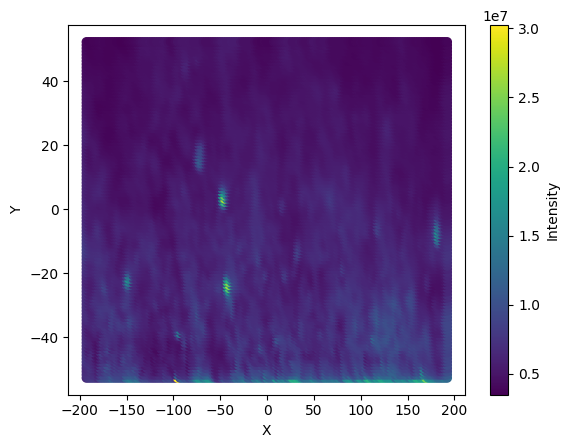

In [5]:
def plot_2D (data_muestra):
  # Seleccionamos la muestra que queremos representar
  intensities = data_muestra.sum(axis=1)
  # Creamos la matriz de intensidades
  # Creamos la matriz de números de onda
  wavenumber = data_muestra.columns.get_level_values(0).astype(float)
  # Creamos la matriz de coordenadas
  X = data_muestra.index.get_level_values('X').astype(float)
  Y = data_muestra.index.get_level_values('Y').astype(float)
  plt.scatter(X, Y, c=intensities, cmap='viridis')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.colorbar(label='Intensity')
  plt.show()
  plt.show()

plot_2D(df)

In [5]:
# df = pd.DataFrame()
# for file in csv_files:
#     file_path = os.path.join(path_nanobase, file)
#     df_final, resultados = procesarRamanNanobase(file_path)
#     df = pd.concat([df, df_final])

D:\OneDrive - UNICAN\RamanNanoBase\CONCHAS_ARQ\CSV\080424_lit1_1000ms_potencia1c_n1_map.CSV: se descartaron 0 espectros saturados de un total de 16430 espectros.
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
AL

: 

In [ ]:
# Guardamos los datos en un CSV
# data.to_csv(f'C:/Users/perezandrea.UNICAN/Documents/CONCHAS/{nombre}.csv',index=True)

In [6]:
df_lit3 = pd.read_csv('C:/Users/perezandrea.UNICAN/Documents/CONCHAS/Lit3.csv', index_col=[0,1,2])

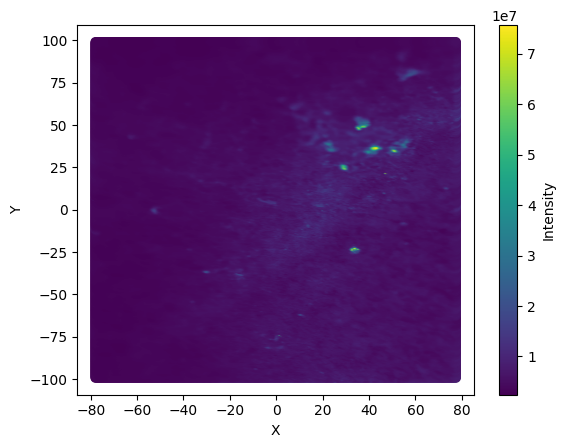

In [7]:
plot_2D(df_lit3)

In [ ]:
df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(path_nanobase, file)
    df_final = pd.read_csv(file_path)
    df = pd.concat([df, df_final])

In [11]:
df_lit3

-77.345  -75.107  -72.871  -70.634  -68.396  \
Muestra X          Y                                                        
Lit 3   -78.011658 -99.27785      312      341      326      276      312   
        -77.501658 -99.27785      300      303      310      320      294   
        -76.991658 -99.27785      286      307      318      320      318   
        -76.481658 -99.27785      302      349      352      316      300   
        -75.971658 -99.27785      318      313      276      302      284   
...                               ...      ...      ...      ...      ...   
         75.498342  99.11215      328      283      300      314      332   
         76.008342  99.11215      302      325      312      294      330   
         76.518342  99.11215      250      307      300      352      294   
         77.028342  99.11215      304      333      314      294      314   
         77.538342  99.11215      332      321      290      296      296   

                              -66.159  -63.924  -61.687  -59.455  -57.216  \
Muestra X          Y                                                        
Lit 3   -78.011658 -99.27785      360      299      320      342      309   
        -77.501658 -99.27785      314      335      384      290      303   
        -76.991658 -99.27785      334      309      296      306      319   
        -76.481658 -99.27785      284      309      288      334      313   
        -75.971658 -99.27785      314      323      314      270      321   
...                               ...      ...      ...      ...      ...   
         75.498342  99.11215      326      315      302      298      297   
         76.008342  99.11215      350      315      310      294      353   
         76.518342  99.11215      256      289      302      322      303   
         77.028342  99.11215      390      329      328      334      313   
         77.538342  99.11215      316      289      308      310      341   

                              ...  3303.863  3305.027  3306.193  3307.363  \
Muestra X          Y          ...                                           
Lit 3   -78.011658 -99.27785  ...      1096      1032      1011      1126   
        -77.501658 -99.27785  ...      1059      1194       971      1099   
        -76.991658 -99.27785  ...       915      1089      1123      1124   
        -76.481658 -99.27785  ...      1098      1069      1051      1014   
        -75.971658 -99.27785  ...      1086      1089      1127      1040   
...                           ...       ...       ...       ...       ...   
         75.498342  99.11215  ...      1494      1678      1575      1596   
         76.008342  99.11215  ...      1608      1710      1644      1868   
         76.518342  99.11215  ...      1842      1785      1791      1773   
         77.028342  99.11215  ...      1950      1769      1669      1872   
         77.538342  99.11215  ...      1867      1895      1932      1986   

                              3308.530  3309.694  3310.858  3312.022  \
Muestra X          Y                                                   
Lit 3   -78.011658 -99.27785      1018      1088       939      1026   
        -77.501658 -99.27785      1114       953      1081      1040   
        -76.991658 -99.27785      1143      1074      1160      1108   
        -76.481658 -99.27785      1162       992      1110      1048   
        -75.971658 -99.27785      1081      1122       996      1135   
...                                ...       ...       ...       ...   
         75.498342  99.11215      1635      1713      1674      1526   
         76.008342  99.11215      1572      1766      1799      1539   
         76.518342  99.11215      1698      1753      1730      1742   
         77.028342  99.11215      1868      1942      1697      1829   
         77.538342  99.11215      1923      2028      1965      2072   

                              3313.186  3314.347  
Muestra X          Y                

In [ ]:
df_l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


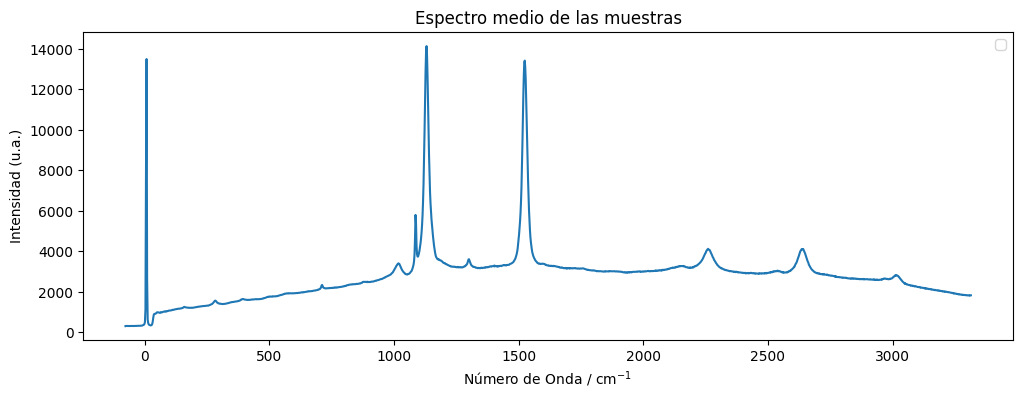

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


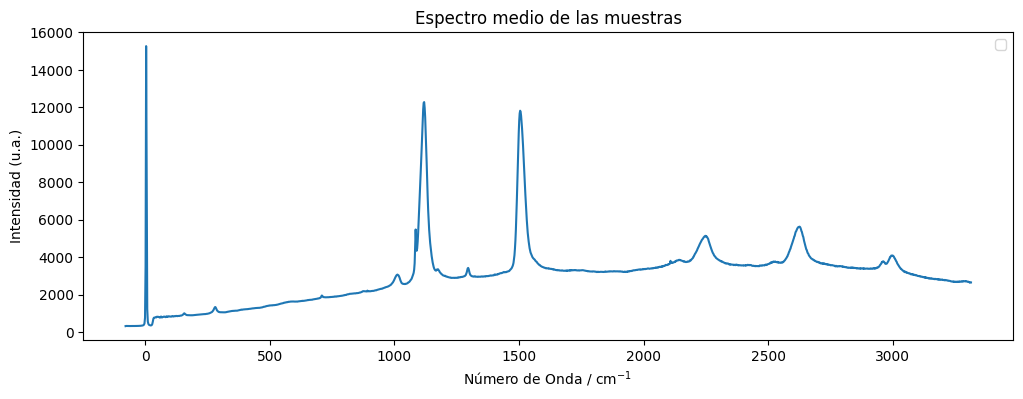

In [9]:
#################### Pintar espectros medios #############################
def avg_spectrum (data_muestra,
                  titulo = "Espectro medio de las muestras"):
  #data = pd.concat(dataframes, axis=0)
  #data = create_df(csv_files, path)

  plt.figure(figsize=(12, 4))

  wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
  mean_intensity = data_muestra.mean(axis=0)
    #color = colores[i % len(colores)]

    # Representa el espectro medio con el color correspondiente
  plt.plot(wavenumber, mean_intensity)#, color=color)

  # Etiquetas y título para el gráfico
  plt.xlabel("Número de Onda / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  plt.title(f'{titulo}')

  plt.legend()
  plt.grid(False)
  plt.show()


avg_spectrum(df_lit3)
avg_spectrum(df)